# Example to connect to postgres

This is a tutorial to connect to our PostgreSQL database using python.

First you need to install the following libraries:
- psycopg2
- python-dotenv

Then you need to create a file with the name ".env". This file will contain the connection information and your credentials. This is an example:

```
DB_HOST=host_name
DB_NAME=postgres
DB_USER=my_user
DB_PASSWORD=my_password
DB_PORT=5432
```

After that you´re all set. We will import your credentials and connect to the database.

In [1]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [3]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

Now we can query our data (write sql code) and store it as a pandas dataframe

In [4]:
query_main="""
    select TO_TIMESTAMP(year || '-' || month || '-' || day || ' ' || hour || ':' || min, 'YYYY-MM-DD HH24:MI') AT TIME ZONE 'UTC' as ts,
    gridimport_wh - gridexport_wh as net_load  
    from agg.t_msb1m  
    where site = 64
"""
df_main = pd.read_sql_query(query_main, conn)

#agg.tidy_data_v2


C:\Users\Zóra\AppData\Local\Temp\ipykernel_18012\64181164.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_main = pd.read_sql_query(query_main, conn)


In [5]:
pd.set_option('display.max_columns', None)

df_main

,ts,net_load
0,2019-03-01 00:00:00,10.680
1,2019-03-01 00:15:00,7.320
2,2019-03-01 00:30:00,7.410
3,2019-03-01 00:45:00,7.630
4,2019-03-01 01:00:00,8.140
...,...,...
38048,2020-03-31 22:45:00,7.510
38049,2020-03-31 23:00:00,7.370
38050,2020-03-31 23:15:00,7.570
38051,2020-03-31 23:30:00,6.810


In [6]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38053 entries, 0 to 38052
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ts        38053 non-null  datetime64[ns]
 1   net_load  38053 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 594.7 KB


## Convert Convert 'ts' to datetime and set as index

In [7]:
df_main['datetime'] = pd.to_datetime(df_main['ts'])
df_main.set_index('datetime', inplace=True)

In [8]:
df_main

,ts,net_load
datetime,,
2019-03-01 00:00:00,2019-03-01 00:00:00,10.680
2019-03-01 00:15:00,2019-03-01 00:15:00,7.320
2019-03-01 00:30:00,2019-03-01 00:30:00,7.410
2019-03-01 00:45:00,2019-03-01 00:45:00,7.630
2019-03-01 01:00:00,2019-03-01 01:00:00,8.140
...,...,...
2020-03-31 22:45:00,2020-03-31 22:45:00,7.510
2020-03-31 23:00:00,2020-03-31 23:00:00,7.370
2020-03-31 23:15:00,2020-03-31 23:15:00,7.570


In [9]:
df_main['net_load_norm'] = df_main['net_load'] / max(abs(df_main['net_load']))
df_main.drop('net_load',axis=1,inplace=True)
df_main.head()

,ts,net_load_norm
datetime,,
2019-03-01 00:00:00,2019-03-01 00:00:00,0.010541
2019-03-01 00:15:00,2019-03-01 00:15:00,0.007225
2019-03-01 00:30:00,2019-03-01 00:30:00,0.007313
2019-03-01 00:45:00,2019-03-01 00:45:00,0.007531
2019-03-01 01:00:00,2019-03-01 01:00:00,0.008034


### Creating function for lagged net_load

In [10]:
#Creating function for lagged net_load

def create_lagged_features(df, lags):
    df_lagged = df.copy()
    for lag in lags:
        df_lagged[f'net_load_lag_{lag}'] = df_lagged['net_load_norm'].shift(lag)
    # Remove rows with NaN values due to shifting
    df_lagged = df_lagged.dropna()
    return df_lagged

# Define your lags
lags = [1,2,3,96,192]

# Prepare your dataset with lagged features
df_lagged = create_lagged_features(df_main, lags)

df_lagged

,ts,net_load_norm,net_load_lag_1,net_load_lag_2,net_load_lag_3,net_load_lag_96,net_load_lag_192
datetime,,,,,,,
2019-03-03 00:00:00,2019-03-03 00:00:00,0.021309,0.017983,0.017598,0.018387,0.008379,0.010541
2019-03-03 00:15:00,2019-03-03 00:15:00,0.042025,0.021309,0.017983,0.017598,0.007442,0.007225
2019-03-03 00:30:00,2019-03-03 00:30:00,0.041818,0.042025,0.021309,0.017983,0.007669,0.007313
2019-03-03 00:45:00,2019-03-03 00:45:00,0.025523,0.041818,0.042025,0.021309,0.007373,0.007531
2019-03-03 01:00:00,2019-03-03 01:00:00,0.016956,0.025523,0.041818,0.042025,0.008557,0.008034
...,...,...,...,...,...,...,...
2020-03-31 22:45:00,2020-03-31 22:45:00,0.007412,0.007343,0.007412,0.007106,0.007333,0.007412
2020-03-31 23:00:00,2020-03-31 23:00:00,0.007274,0.007412,0.007343,0.007412,0.006771,0.007304
2020-03-31 23:15:00,2020-03-31 23:15:00,0.007471,0.007274,0.007412,0.007343,0.007462,0.007205


#### get_input function

In [11]:
def get_input(ts, lags):
    # Convert lags to positions from the end of the series
    positions = [ - 1 - lag for lag in lags]
    # Use iloc to get values at positions
    return ts.iloc[positions].values.reshape(1, -1)

In [12]:
[ - 1 - lag for lag in lags]

[-2, -3, -4, -97, -193]

Previous (wrong) rolling prediciton model

In [13]:
#def rolling_prediction(model, initial_ts, steps_ahead, lags):
    # 'initial_ts' is expected to be a Pandas Series with enough past observations to cover all lags.
    # initial_ts needs to be a series with at least 192 past observations.
    #HOW DO I MAKE SURE THSI IS THE CASE? I only have now lags 1,2,3,96,192
    #ts = initial_ts.copy()
    #predictions = []

    #for i in range(steps_ahead):
        # Get the input for the current prediction.
        # Ensure that 'get_input' retrieves the last known observations from 'ts'
        # for all required lags.
        #input_features = get_input(ts, lags)
        
        # Predict the next step using the RF model.
        #pred = model.predict(input_features)[0]
        
        # Append the prediction to the list of predictions.
        #predictions.append(pred)
        
        # Also append the prediction to 'ts' for subsequent predictions.
        # The 'ts' will now include the most recent prediction at the end.
        #ts = ts.append(pd.Series(pred), ignore_index=True)
        
    # Return only the predictions made, not the entire series.
    #return predictions

#### Create initial_ts by taking the last 192 observations (48 hours) from this point backward to cover all lags

In [14]:
# Assuming 'df_main' has a DateTimeIndex and 'net_load' is your target column.

# Identify the time point for initial_ts
end_time = df_main.index[-1]
start_time = end_time - pd.Timedelta(hours=48)  # 192 intervals of 15 minutes is equivalent to 48 hours

# Make sure you don't go out of bounds
if start_time < df_main.index[0]:
    raise ValueError("Not enough data points for the required lags.")

# Create initial_ts for rolling predictions
# We select the data between 'start_time' and 'end_time', including all necessary lags.
initial_ts = df_main.loc[start_time:end_time]['net_load_norm']

In [15]:
initial_ts

datetime
2020-03-29 23:45:00    0.010300
2020-03-30 00:00:00    0.007136
2020-03-30 00:15:00    0.007639
2020-03-30 00:30:00    0.007619
2020-03-30 00:45:00    0.007165
                         ...   
2020-03-31 22:45:00    0.007412
2020-03-31 23:00:00    0.007274
2020-03-31 23:15:00    0.007471
2020-03-31 23:30:00    0.006721
2020-03-31 23:45:00    0.009105
Name: net_load_norm, Length: 193, dtype: float64

### Define features and target, train and test

In [16]:
# Define features and target
y = df_lagged['net_load_norm']
X = df_lagged[[f'net_load_lag_{lag}' for lag in lags]]

# Split data into training and testing sets
#train_size = int(len(df_lagged) * 0.8)
#train_features, test_features = X.iloc[:train_size], X.iloc[train_size:]
#train_target, test_target = y.iloc[:train_size], y.iloc[train_size:]

# Reserve the last 96 observations for testing
train_features = X.iloc[:-96]
test_features = X.iloc[-96:]

train_target = y.iloc[:-96]
test_target = y.iloc[-96:]

### Model definition and training 

In [17]:
rf = RandomForestRegressor()

# TRAIN the model
rf.fit(train_features, train_target)

# TEST the model - Predict on the test set - Make predictions for the test set
y_pred = rf.predict(test_features)


In [18]:
# error metric MAE and normalized MAE
mae = mean_absolute_error(test_target, y_pred)
print(f'Mean Absolute Error: {mae}')

target_range = train_target.max() -train_target.min()
normalized_mae = mae / target_range
print(f'Normalized MAE: {normalized_mae}')

Mean Absolute Error: 0.030645250580768613
Normalized MAE: 0.01806689624603442


In [19]:
print(train_target.tail())
print(train_target.iloc[-2])
print(get_input(train_target, lags))

datetime
2020-03-30 22:45:00    0.007333
2020-03-30 23:00:00    0.006771
2020-03-30 23:15:00    0.007462
2020-03-30 23:30:00    0.007037
2020-03-30 23:45:00    0.010702
Name: net_load_norm, dtype: float64
0.007037110146071851
[[0.00703711 0.00746151 0.00677063 0.01029976 0.00730359]]


In [20]:
input_features = get_input(train_target, lags)
pred = rf.predict(input_features)

print(input_features)
print(pred)

[[0.00703711 0.00746151 0.00677063 0.01029976 0.00730359]]
[0.00923035]


C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [21]:
initial_ts

datetime
2020-03-29 23:45:00    0.010300
2020-03-30 00:00:00    0.007136
2020-03-30 00:15:00    0.007639
2020-03-30 00:30:00    0.007619
2020-03-30 00:45:00    0.007165
                         ...   
2020-03-31 22:45:00    0.007412
2020-03-31 23:00:00    0.007274
2020-03-31 23:15:00    0.007471
2020-03-31 23:30:00    0.006721
2020-03-31 23:45:00    0.009105
Name: net_load_norm, Length: 193, dtype: float64

### Rolling origin prediction

Create a function that performs sequential predictions over a specified number of steps, using each prediction as input for the next

In [22]:

def rolling_window_predictions(model, full_series, test_series, lags):
    """
    Generate rolling window predictions and plot against actual data.
    
    :model: pre-trained RF
    :full_series: COMPLETE time series data with both training and test data
    :test_series: series containing the TEST data with actual values to compare against
    :param lags: List of integers representing the lag intervals.
    """
    initial_ts = full_series.copy()#[-max(lags):] # Initial time series for rolling predictions    
    predictions = []  # Store out-of-sample predictions
    
    for actual_value in test_series: # Iterate over the test set to predict one step ahead each time
        
        #print("pre func")
        input_features = get_input(initial_ts, lags).reshape(1, -1) # Get the input features for the current prediction
        #print("post func")

        pred = model.predict(input_features)[0] # Predict the next time step and store the prediction
        predictions.append(pred)
        
        # Append the actual observed value to roll the window forward
        initial_ts = pd.concat([initial_ts, pd.Series([pred])], ignore_index=True)
        
        # Ensure that initial_ts only contains the most recent data needed for the next prediction
        #if len(initial_ts) > max(lags):
         #   initial_ts = initial_ts.tail(max(lags))
        
    plt.figure(figsize=(15, 7))
    plt.plot(test_series.index, test_series, label='Actual Data', color='blue')
    plt.plot(test_series.index, predictions, label='Rolling Window Predictions', color='orange')
    plt.legend()
    plt.xlabel('Date Time')
    plt.ylabel('Normalised Net Load')
    plt.title('Rolling Window Predictions vs Actual Data')
    plt.show()
    
    return predictions

C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:

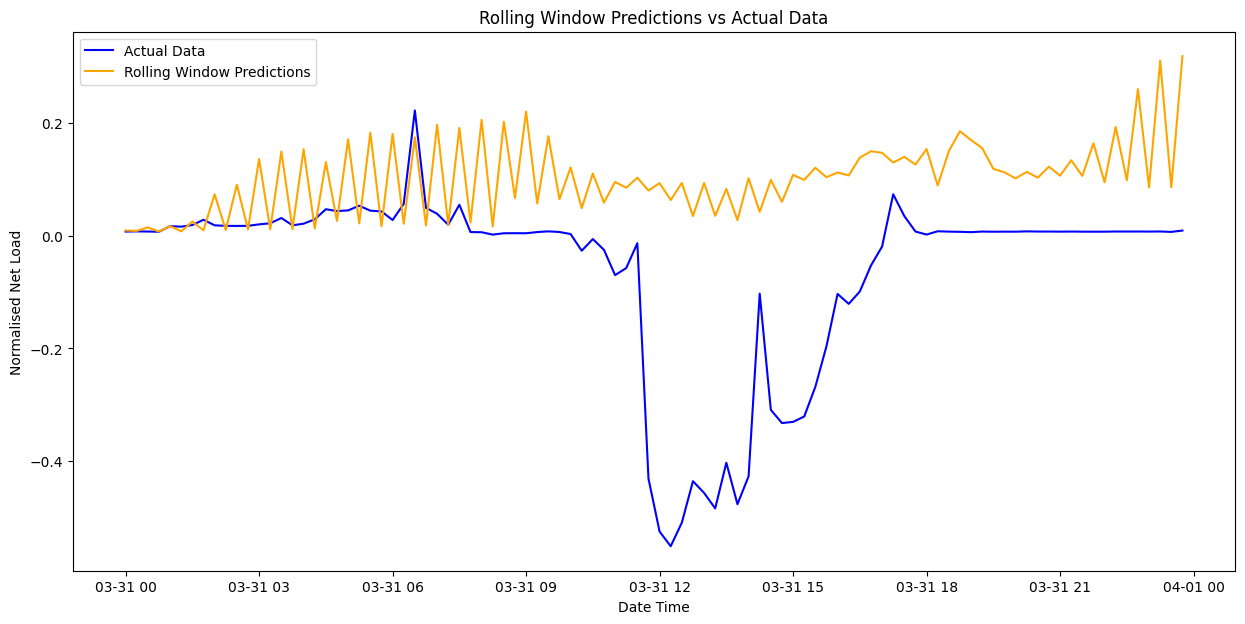

In [23]:
predicted_values = rolling_window_predictions(rf, train_target, test_target, lags=[1,2,3,96,192])

## Trying to make changes to 
- Checking whether a single prediction outside the loop is made using known inputs and check if the prediction is reasonable
- Checking if initial_ts is being updated correctly after each prediction by printing its last few entries at each step

In [32]:
# Select a known point from the training set
example_point = train_features.iloc[-1]  # This should be a DataFrame row

# Predict using the known point
example_prediction = rf.predict(example_point.values.reshape(1, -1))

print(f"Prediction for known input: {example_prediction}")

# Compare this prediction with the actual value from the training set
example_actual = train_target.iloc[-1]
print(f"Actual value for the known input: {example_actual}")

Prediction for known input: [0.00923035]
Actual value for the known input: 0.010701595933675484


C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Trying to make changes to rolling_window_predictions through different methods
Trying new get_input function as well

In [24]:
def get_input_2(ts, lags):
    return np.array([ts.iloc[-lag] if lag <= len(ts) else 0 for lag in lags]).reshape(1, -1)


In [25]:
def rolling_window_predictions_2(model, full_series, test_series, lags):
    """
    Generate rolling window predictions and plot against actual data.
    
    :model: pre-trained RF
    :full_series: COMPLETE time series data with both training and test data
    :test_series: series containing the TEST data with actual values to compare against
    :param lags: List of integers representing the lag intervals.
    """
    initial_ts = full_series[-max(lags):] # Initial time series for rolling predictions    
    predictions = []  # Store out-of-sample predictions
    
    for time_step in range(len(test_series)): # Iterate over the test set to predict one step ahead each time
        
        #print("pre func")
        
        input_features = get_input(initial_ts, lags)#.reshape(1, -1) # Get the input features for the current prediction
        #input_features = get_input_2(initial_ts, lags)
        
        #print("post func")

        pred = model.predict(input_features)[0] # Predict the next time step and store the prediction
        predictions.append(pred)

            # Calculate the next timestamp by adding the 15-minute interval
        next_timestamp = initial_ts.index[-1] + pd.Timedelta(minutes=15)

        if len(predictions) != len(test_series):
            print("Mismatch: The predictions and actual values are not aligned.")
        
        # Append the actual observed value to roll the window forward
        temp_df = pd.DataFrame([pred], index=[next_timestamp], columns=['net_load'])
        initial_ts = pd.concat([initial_ts, temp_df])
        initial_ts = initial_ts.tail(max(lags))
        #initial_ts = pd.concat([initial_ts, pd.Series([pred])], ignore_index=True)
        #initial_ts = initial_ts.append(pd.Series(pred)).iloc[-max(lags):]
        
        # Ensure that initial_ts only contains the most recent data needed for the next prediction
        #if len(initial_ts) > max(lags):
        #initial_ts = initial_ts.tail(max(lags))
        
    plt.figure(figsize=(15, 7))
    plt.plot(test_series.index, test_series, label='Actual Data', color='blue')
    plt.plot(test_series.index, predictions, label='Rolling Window Predictions', color='orange')
    plt.legend()
    plt.xlabel('Date Time')
    plt.ylabel('Normalised Net Load')
    plt.title('Rolling Window Predictions vs Actual Data')
    plt.show()
    
    return predictions

C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:

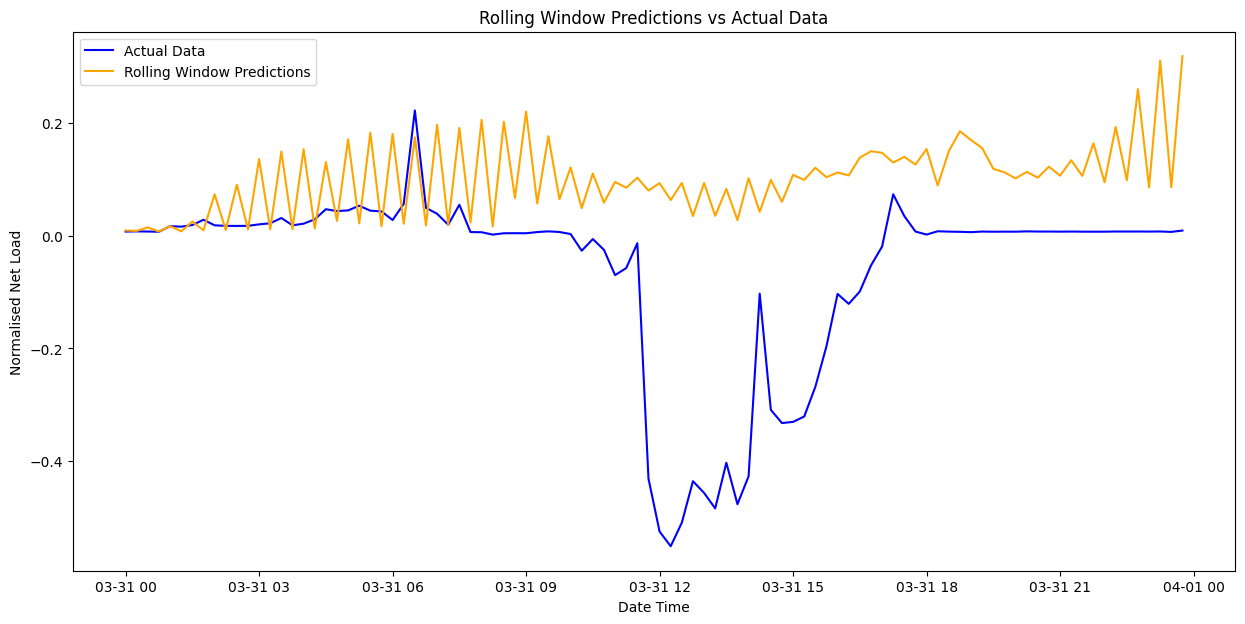

In [26]:
predicted_values = rolling_window_predictions(rf, train_target, test_target, lags=[1,2,3,96,192])

In [27]:
def get_input_features_df(ts, lags):
    # Create a DataFrame for input features with proper column names
    features = pd.DataFrame(index=[0])
    for lag in lags:
        # Use iloc for position-based indexing
        index_position = -lag if lag <= len(ts) else None
        features[f'net_load_lag_{lag}'] = ts.iloc[index_position]
    return features

In [28]:
def rolling_window_predictions_2(model, full_series, test_series, lags):
    initial_ts = full_series[-max(lags):]
    predictions = []

    for time_step in range(len(test_series)):
        input_features_df = get_input_2(initial_ts, lags)  # Make sure this returns a DataFrame
        pred = model.predict(input_features_df)[0]
        predictions.append(pred)

        # Create the next timestamp
        next_timestamp = initial_ts.index[-1] + pd.Timedelta(minutes=15)
        # Append the predicted value with its timestamp
        temp_df = pd.DataFrame([pred], index=[next_timestamp], columns=['net_load'])
        initial_ts = pd.concat([initial_ts, temp_df])
        initial_ts = initial_ts.tail(max(lags))
        #initial_ts = full_series[-max(lags):]

    # After the loop, check for a mismatch
    if len(predictions) != len(test_series):
        print("Mismatch: The number of predictions does not match the number of actual values.")

    # Plotting
    plt.figure(figsize=(15, 7))
    plt.plot(test_series.index, test_series, label='Actual Data', color='blue')
    plt.plot(test_series.index, predictions, label='Rolling Window Predictions', color='orange')
    plt.legend()
    plt.xlabel('Date Time')
    plt.ylabel('Normalised Net Load')
    plt.title('Rolling Window Predictions vs Actual Data')
    plt.show()

    return predictions


In [29]:
predicted_values = rolling_window_predictions_2(rf, train_target, test_target, lags=[1,2,3,96,192])

C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 10 features, but RandomForestRegressor is expecting 5 features as input.

In [ ]:
def get_input_2(ts, lags):
    return np.array([ts.iloc[-lag] if lag <= len(ts) else 0 for lag in lags]).reshape(1, -1)

def get_input(ts, lags):
    # Convert lags to positions from the end of the series
    positions = [ - 1 - lag for lag in lags]
    # Use iloc to get values at positions
    return ts.iloc[positions].values.reshape(1, -1) #what is the difference between these two get_input functions. Can you explain what does each one do?

def get_input_2(ts, lags):
    # Assuming ts is a pandas Series with DateTimeIndex
    lagged_values = [ts.shift(lag) for lag in lags]
    # Combine lagged values into a DataFrame
    input_df = pd.concat(lagged_values, axis=1)
    # Rename columns to match training feature names
    input_df.columns = [f'net_load_lag_{lag}' for lag in lags]
    return input_df.iloc[-1:].values  # Return the last row as input features

In [ ]:
print(get_input_2(train_target, lags))
print(get_input(train_target, lags))

[[0.0107016  0.00703711 0.00746151 0.00713581 0.00746151]]
[[0.00703711 0.00746151 0.00677063 0.01029976 0.00730359]]


In [ ]:
predicted_values = rolling_window_predictions_2(rf, train_target, test_target, lags=[1,2,3,96,192])

C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 10 features, but RandomForestRegressor is expecting 5 features as input.

In [ ]:
def rolling_window_predictions_3(model, full_series, test_series, lags):
    """
    Generate rolling window predictions and plot against actual data.
    
    :model: pre-trained RF
    :full_series: COMPLETE time series data with both training and test data
    :test_series: series containing the TEST data with actual values to compare against
    :param lags: List of integers representing the lag intervals.
    """
    initial_ts = full_series[-max(lags):] # Initial time series for rolling predictions    
    predictions = []  # Store out-of-sample predictions
    
    for time_step in range(len(test_series)): # Iterate over the test set to predict one step ahead each time
        
        #print("pre func")
        input_features = get_input_2(initial_ts, lags)#.reshape(1, -1) # Get the input features for the current prediction
        #print("post func")

        pred = model.predict(input_features)[0] # Predict the next time step and store the prediction
        predictions.append(pred)

        #if len(predictions) != len(test_series):
            #print("Mismatch: The predictions and actual values are not aligned.")
        
        # Update initial_ts by appending the prediction at the correct frequency
        next_timestamp = initial_ts.index[-1] + pd.Timedelta(minutes=15) # assumes 15-minute intervals
        initial_ts = initial_ts = pd.concat([initial_ts, pd.Series([pred])], ignore_index=True)

        # Drop the oldest observation to maintain the series size
        initial_ts = initial_ts.tail(max(lags))

        
        # Append the actual observed value to roll the window forward
        #initial_ts = pd.concat([initial_ts, pd.Series([pred])], ignore_index=True)
        #initial_ts = initial_ts.append(pd.Series(pred)).iloc[-max(lags):]
        
        # Ensure that initial_ts only contains the most recent data needed for the next prediction
        #if len(initial_ts) > max(lags):
         #   initial_ts = initial_ts.tail(max(lags))
        
    plt.figure(figsize=(15, 7))
    plt.plot(test_series.index, test_series, label='Actual Data', color='blue')
    plt.plot(test_series.index, predictions, label='Rolling Window Predictions', color='orange')
    plt.legend()
    plt.xlabel('Date Time')
    plt.ylabel('Normalised Net Load')
    plt.title('Rolling Window Predictions vs Actual Data')
    plt.show()
    
    return predictions

In [ ]:
predicted_values = rolling_window_predictions_3(rf, train_target, test_target, lags=[1,2,3,96,192])

C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


TypeError: unsupported operand type(s) for +: 'int' and 'Timedelta'

# . 

# . 

### Rolling origin prediction for multiple steps ahead - Wrong approaches

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def rolling_window_predictions(model, full_series, steps_ahead, lags):
    """
    Generate rolling window predictions for a specified number of steps ahead.

    :param model: The pre-trained machine learning model.
    :param full_series: Complete time series data, containing both training and (optionally) test data.
    :param steps_ahead: Number of future steps to predict.
    :param lags: List of integers representing the lag intervals.
    :return: A tuple (predictions, prediction_series) containing the list of prediction values and
             the corresponding pandas Series with timestamps.
    """
    # Initialize the initial time series for rolling predictions
    initial_ts = full_series[-max(lags):]
    
    # Store the out-of-sample predictions
    predictions = []
    
    # Iterate to predict the specified number of steps ahead
    for step in range(steps_ahead):
        # Get the input features for the current prediction
        input_features = get_input(initial_ts, lags).reshape(1, -1)
        
        # Predict the next time step and store the prediction
        pred = model.predict(input_features)[0]
        predictions.append(pred)
        
        # Append the predicted value to roll the window forward
        initial_ts = pd.concat([initial_ts, pd.Series([pred])], ignore_index=True)
        
        # Ensure that initial_ts only contains the most recent data needed for the next prediction
        if len(initial_ts) > max(lags):
            initial_ts = initial_ts.tail(max(lags))
    
    # Generate the datetime index for the prediction series
    last_timestamp = full_series.index[-1]
    prediction_index = pd.date_range(start=last_timestamp, periods=steps_ahead, freq='15T')
    
    # Create the prediction series
    prediction_series = pd.Series(data=predictions, index=prediction_index)

    # Plot the prediction series
    plt.figure(figsize=(15, 7))
    plt.plot(prediction_series.index, prediction_series, label='Rolling Window Predictions', color='red')
    plt.legend()
    plt.xlabel('Date Time')
    plt.ylabel('Net Load')
    plt.title('Rolling Window Predictions')
    plt.show()
    
    return predictions, prediction_series

# Usage example:
# rf_model - your pre-trained RandomForestRegressor
# df_main['net_load'] - the full series including training data
# steps_ahead - how far into the future you want to predict
# lags - the lags used for predictions

# Example call to the function:
predicted_values, prediction_series = rolling_window_predictions(rf, df_main['net_load_norm'], steps_ahead=30*24*4, lags=[1,2,3,96,192])


IndexError: positional indexers are out-of-bounds

In [ ]:
def rolling_window_predictions_steps(model, full_series, test_series, lags, steps_ahead):
    """
    Generate rolling window predictions for a specified number of steps ahead and plot against actual data.
    
    :param model: The pre-trained machine learning model.
    :param full_series: Complete time series data, containing both training and test data.
    :param test_series: Series containing the test data with actual values to compare against.
    :param lags: List of integers representing the lag intervals.
    :param steps_ahead: Integer, number of future steps to predict.
    """
    # Initialize the initial time series for rolling predictions
    initial_ts = full_series[-max(lags):]
    
    # Store the out-of-sample predictions
    predictions = []
    
    # Use a counter to keep track of the number of steps predicted
    steps_predicted = 0
    
    # Iterate over the test set to predict one step ahead each time
    for actual_value in test_series:
        if steps_predicted >= steps_ahead:
            break  # Stop prediction if we reached the desired number of steps
        
        # Get the input features for the current prediction
        input_features = get_input(initial_ts, lags).reshape(1, -1)
        
        # Predict the next time step and store the prediction
        pred = model.predict(input_features)[0]
        predictions.append(pred)
        
        # Append the actual observed value to roll the window forward
        initial_ts = pd.concat([initial_ts, pd.Series([actual_value])], ignore_index=True)
        
        # Ensure that initial_ts only contains the most recent data needed for the next prediction
        if len(initial_ts) > max(lags):
            initial_ts = initial_ts.tail(max(lags))
        
        # Increment the counter
        steps_predicted += 1
    
    # Generate an index for the predicted values (assuming test_series has a DateTime index)
    predicted_index = pd.date_range(start=test_series.index[0], periods=steps_predicted, freq=test_series.index.freq)
    
    # Plot the actual vs predicted data up to the steps ahead
    plt.figure(figsize=(15, 7))
    plt.plot(predicted_index, test_series[:steps_predicted], label='Actual Data', color='blue')
    plt.plot(predicted_index, predictions, label='Rolling Window Predictions', color='red', linestyle='--')
    plt.legend()
    plt.xlabel('Date Time')
    plt.ylabel('Net Load')
    plt.title('Rolling Window Predictions vs Actual Data')
    plt.show()
    
    return predictions

# Example call to the function with steps_ahead parameter:
predicted_values = rolling_window_predictions_steps(
    rf, df_main['net_load'], test_target, lags=[1,2,3,96,192], steps_ahead=720  # For example, 720 steps of 15 minutes each
)


KeyError: 'net_load'